## Detection of differences in the genes of cancer patients

We will use the data of Stanford School of Medicine. The study attempts to identify a set of genes that would allow more accurately diagnose the occurrence of breast cancer in the earliest stages.

Scientists made a sequencing of the biological material of the subjects in order to understand which of these genes are most active in the cells of sick people.

Data contains the result information for each of 15748 genes.

Our goal is to identify the genes whose activity at different phases of the disease differs significantly.

In [1]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.multitest as smm
from statsmodels.stats.weightstats import *
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('gene_high_throughput_sequencing.csv')
data.head()

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917


In the experiment we have 24 people who had no breast cancer (normal), 25 people who had this disease which was diagnosed at an early stage (early neoplasia), and 23 people with severe symptoms (cancer).

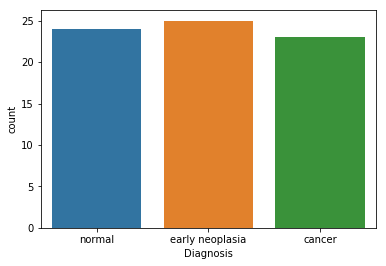

In [3]:
sns.countplot(x = "Diagnosis", data = data)

Identify genes whose activity in different phases of the disease differs statistically significant.
To achive this we need to apply the Student’s criteria to test the hypothesis of equality of the means in two independent samples. We will apply the criteria for each gene twice:
* for groups normal (control) and early neoplasia (treatment)
* for groups early neoplasia (control) and cancer (treatment)

In [5]:
genes = data.columns
genes = genes[2:]

In [6]:
p_values_1group = []
p_values_2group = []
for gene in genes:
    p = sc.stats.ttest_ind(data[data.Diagnosis == 'normal'][gene], data[data.Diagnosis == 'early neoplasia'][gene], equal_var=False)
    p_values_1group.append(p[1])
    p = sc.stats.ttest_ind(data[data.Diagnosis == 'early neoplasia'][gene], data[data.Diagnosis == 'cancer'][gene], equal_var=False)
    p_values_2group.append(p[1])

In [8]:
hypotesis = pd.DataFrame(genes)
hypotesis['normal - early neoplasia'] = p_values_1group
hypotesis['early neoplasia - cancer'] = p_values_2group
hypotesis.columns = ['gen', 'normal - early neoplasia', 'early neoplasia - cancer']
hypotesis.head()

,gen,normal - early neoplasia,early neoplasia - cancer
0,LOC643837,0.690766,0.413735
1,LOC100130417,0.000032,0.653429
2,SAMD11,0.060273,0.079556
3,NOC2L,0.826429,0.287581
4,KLHL17,0.049876,0.463292


Calculate the number of statistically significant differences that we found using the Student's t-test, that is, the number of genes in which the p-value of this test was less than the level of significance.

In [9]:
(hypotesis['normal - early neoplasia'] < 0.05).value_counts()

False    14173
True      1575
Name: normal - early neoplasia, dtype: int64

In [10]:
(hypotesis['early neoplasia - cancer'] < 0.05).value_counts()

False    12258
True      3490
Name: early neoplasia - cancer, dtype: int64

So, in the first case we found 1575 genes for which the means are equale for control and treatment groups. In the second case - 3490. 

Let's make correction of the test with 2 methods.

### Hill-Bonferroni Method
Since the hypotheses are tested on 2 data sets, we add the Bonferroni correction to the Hill method and use alpha = 0.05 / 2.
Then we apply the folde-change metric for those genes where the differences will be statistically significant and count the number of genes for which the absolute value of this metric will be more than 1.5

In [11]:
reject, p_corrected, a1, a2 = smm.multipletests(hypotesis['normal - early neoplasia'], 
                                            alpha = 0.025, method = 'holm') 
hypotesis['reject'] = reject
hypotesis.reject.value_counts()

False    15746
True         2
Name: reject, dtype: int64

In [12]:
genes_names = hypotesis[hypotesis.reject == True].gen
folde_change = []
for item in genes_names:
    c = np.mean(data[data.Diagnosis == 'normal'][item])
    t = np.mean(data[data.Diagnosis == 'early neoplasia'][item])
    if t > c: folde_change.append(t/c)
    if t < c: folde_change.append(-c/t)
print(sum(1 for i in folde_change if abs(i) > 1.5))

2


/Users/luda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [13]:
reject, p_corrected, a1, a2 = smm.multipletests(hypotesis['early neoplasia - cancer'], 
                                            alpha = 0.025, method = 'holm') 
hypotesis['reject'] = reject
hypotesis.reject.value_counts()

False    15669
True        79
Name: reject, dtype: int64

In [14]:
genes_names = hypotesis[hypotesis.reject == True].gen
folde_change = []
for item in genes_names:
    c = np.mean(data[data.Diagnosis == 'early neoplasia'][item])
    t = np.mean(data[data.Diagnosis == 'cancer'][item])
    if t > c: folde_change.append(t/c)
    if t < c: folde_change.append(-c/t)
print(sum(1 for i in folde_change if abs(i) > 1.5))

77


/Users/luda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


Here we have fewer genes, in which the mean values for the groups do not coincide.

### Benjamin-Hochberg Method
Repeate the same steps.

In [15]:
reject, p_corrected, a1, a2 = smm.multipletests(hypotesis['normal - early neoplasia'], 
                                            alpha = 0.025, method = 'fdr_bh') 
hypotesis['reject'] = reject
hypotesis.reject.value_counts()

False    15744
True         4
Name: reject, dtype: int64

In [16]:
genes_names = hypotesis[hypotesis.reject == True].gen
folde_change = []
for item in genes_names:
    c = np.mean(data[data.Diagnosis == 'normal'][item])
    t = np.mean(data[data.Diagnosis == 'early neoplasia'][item])
    if t > c: folde_change.append(t/c)
    if t < c: folde_change.append(-c/t)
print(sum(1 for i in folde_change if abs(i) > 1.5))

4


/Users/luda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [17]:
reject, p_corrected, a1, a2 = smm.multipletests(hypotesis['early neoplasia - cancer'], 
                                            alpha = 0.025, method = 'fdr_bh') 
hypotesis['reject'] = reject
hypotesis.reject.value_counts()

False    14916
True       832
Name: reject, dtype: int64

In [18]:
genes_names = hypotesis[hypotesis.reject == True].gen
folde_change = []
for item in genes_names:
    c = np.mean(data[data.Diagnosis == 'early neoplasia'][item])
    t = np.mean(data[data.Diagnosis == 'cancer'][item])
    if t > c: folde_change.append(t/c)
    if t < c: folde_change.append(-c/t)
print(sum(1 for i in folde_change if abs(i) > 1.5))

524


/Users/luda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


Thus, in this analysis, for each method we obtained not only the number of genes with statistically significant differences, but also the number of genes with practically significant differences. Further, the task of biologists is to investigate these genes in more detail.